In [ ]:
import sys
import os
import satpy
from pathlib import Path
from satpy import Scene
from pyresample.geometry import AreaDefinition

# 1. RUTAS
current_dir = Path(os.getcwd())
root_path = current_dir.parent.parent
sys.path.append(str(root_path / "src"))

# 2. CONFIGURACIÓN
BASE_PROCESSOR = root_path / "src" / "goes_processor"
CUSTOM_CONFIG = BASE_PROCESSOR / "satpy_config"

# Registramos tus YAMLs
satpy.config.set(config_path=[str(CUSTOM_CONFIG)] + satpy.config.get("config_path", []))

# 3. CARGA DE ESCENA
nc_files = list(current_dir.glob("*.nc"))
scn = Scene(reader="abi_l2_nc", filenames=[str(nc_files[0])])

product_color = "lst_celsius_color01"
scn.load([product_color])

# 4. REMUESTREO
area_def = AreaDefinition('wgs84', 'Global', 'epsg4326', 'EPSG:4326', 3600, 1800, [-180, -90, 180, 90])
resampled_scn = scn.resample(area_def, resampler='kd_tree')

# --- 5. CORRECCIÓN CRÍTICA PARA CELSIUS ---
# Si no hacemos esto, verás todo ROJO porque los datos están en ~300K
print("🌡️ Convirtiendo datos a Celsius para que coincidan con el YAML...")
if resampled_scn[product_color].mean() > 100:
    # Restamos para entrar en el rango -60 a 60 del enhancement
    resampled_scn[product_color] = resampled_scn[product_color] - 273.15
    # Actualizamos unidades para que Satpy no se confunda
    resampled_scn[product_color].attrs['units'] = 'Celsius'

# 6. MOSTRAR
print(f"🚀 Ejecutando .show() para {product_color}...")
resampled_scn.show(product_color)

In [ ]:
import sys
import os
import glob
import satpy
from pathlib import Path
from satpy import Scene
from pyresample import AreaDefinition
import matplotlib.pyplot as plt

# 1. SETUP DE RUTAS DINÁMICO
# Asumimos que el script está en la raíz o en una carpeta 'scripts'
# Retrocedemos hasta encontrar la raíz del proyecto
current_path = Path(os.getcwd())
root_path = current_path if (current_path / "src").exists() else current_path.parent

# Añadimos 'src' al path para poder importar goes_processor
sys.path.append(str(root_path / "src"))

# 2. CONFIGURACIÓN GLOBAL DE SATPY (Igual que en tu main.py)
BASE_DIR = root_path / "src" / "goes_processor"
CUSTOM_CONFIG = BASE_DIR / "satpy_config"
CACHE_DIR = BASE_DIR / "satpy_cache"

# Registrar los paths en Satpy
current_paths = satpy.config.get("config_path", [])
if str(CUSTOM_CONFIG) not in current_paths:
    satpy.config.set(config_path=[str(CUSTOM_CONFIG)] + current_paths)

satpy.config.set(cache_dir=str(CACHE_DIR))
os.environ['PYRESAMPLE_CACHE_DIR'] = str(CACHE_DIR)

print(f"✅ Satpy Config Path: {satpy.config.get('config_path')}")
print(f"✅ Satpy Cache: {satpy.config.get('cache_dir')}")



In [ ]:

input_file = "OR_ABI-L2-LSTF-M6_G19_s20260030000228_e20260030009536_c20260030015142.nc"
print(f"🚀 Procesando archivo: {Path(input_file).name}")

# 4. CARGAR ESCENA Y PRODUCTOS
scn = Scene(reader="abi_l2_nc", filenames=[input_file])

# Cargamos el producto de tu tesis (Celsius + Color)
# Asegúrate de que este nombre coincida con tu enhancements/abi.yaml
product = "lst_celsius_color01" 
raw_product = "LST"

scn.load([product, raw_product])

# 5. CONVERSIÓN CIENTÍFICA (Kelvin a Celsius)
if scn[raw_product].mean() > 100:
    scn[raw_product] = scn[raw_product] - 273.15
    scn[raw_product].attrs['units'] = 'Celsius'

# 6. REPROYECCIÓN WGS84 (3600x1800)
area_def = AreaDefinition(
    'global_wgs84', 'Global WGS84', 'epsg4326', 'EPSG:4326', 
    3600, 1800, [-180, -90, 180, 90]
)

print("🔄 Remuestreando...")
resampled_scn = scn.resample(area_def, resampler='kd_tree')

# 7. GUARDAR RESULTADOS
output_test = root_path / "test_outputs"
output_test.mkdir(exist_ok=True)

# Guardar GeoTIFF de Color
resampled_scn.save_dataset(
    product, 
    filename=str(output_test / 'LST_Color_Test_v0.3.1.tif'),
    writer='geotiff'
)

# Guardar GeoTIFF de Datos (Celsius)
resampled_scn.save_dataset(
    raw_product, 
    filename=str(output_test / 'LST_Data_Celsius_Test_v0.3.1.tif'),
    writer='geotiff'
)

# 8. VISUALIZAR (Si es Notebook)
try:
    resampled_scn.show(product)
except Exception as e:
    print(f"Aviso: .show() requiere entorno gráfico. Error: {e}")

print(f"✅ Proceso terminado. Archivos en: {output_test}")

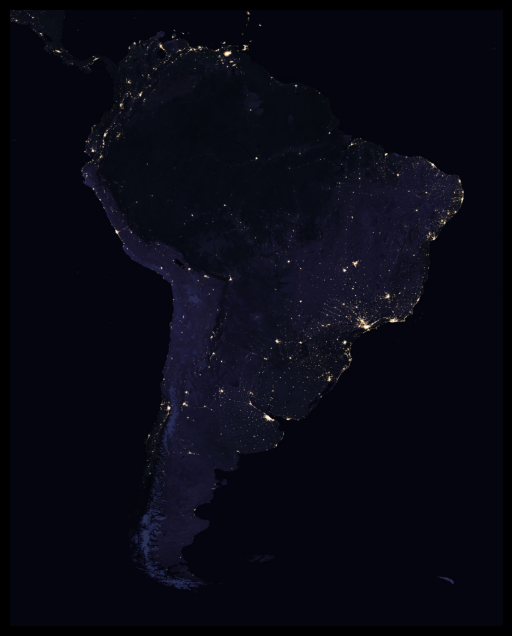

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import urllib.request
from pathlib import Path

# 1. Download the NASA Black Marble background (Low res for fast loading)
url = "https://eoimages.gsfc.nasa.gov/images/imagerecords/144000/144898/BlackMarble_2016_3km.jpg"
img_path = Path("night_lights_bg.jpg")

if not img_path.exists():
    print("Downloading night lights map...")
    urllib.request.urlretrieve(url, img_path)

# 2. Load and Plot
img = plt.imread(img_path)

fig = plt.figure(figsize=(15, 8), facecolor='black')
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to South America to see city lights clearly
ax.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())

# Display the image
# Extent is global [-180, 180, -90, 90]
ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree())

plt.axis('off')
plt.show()

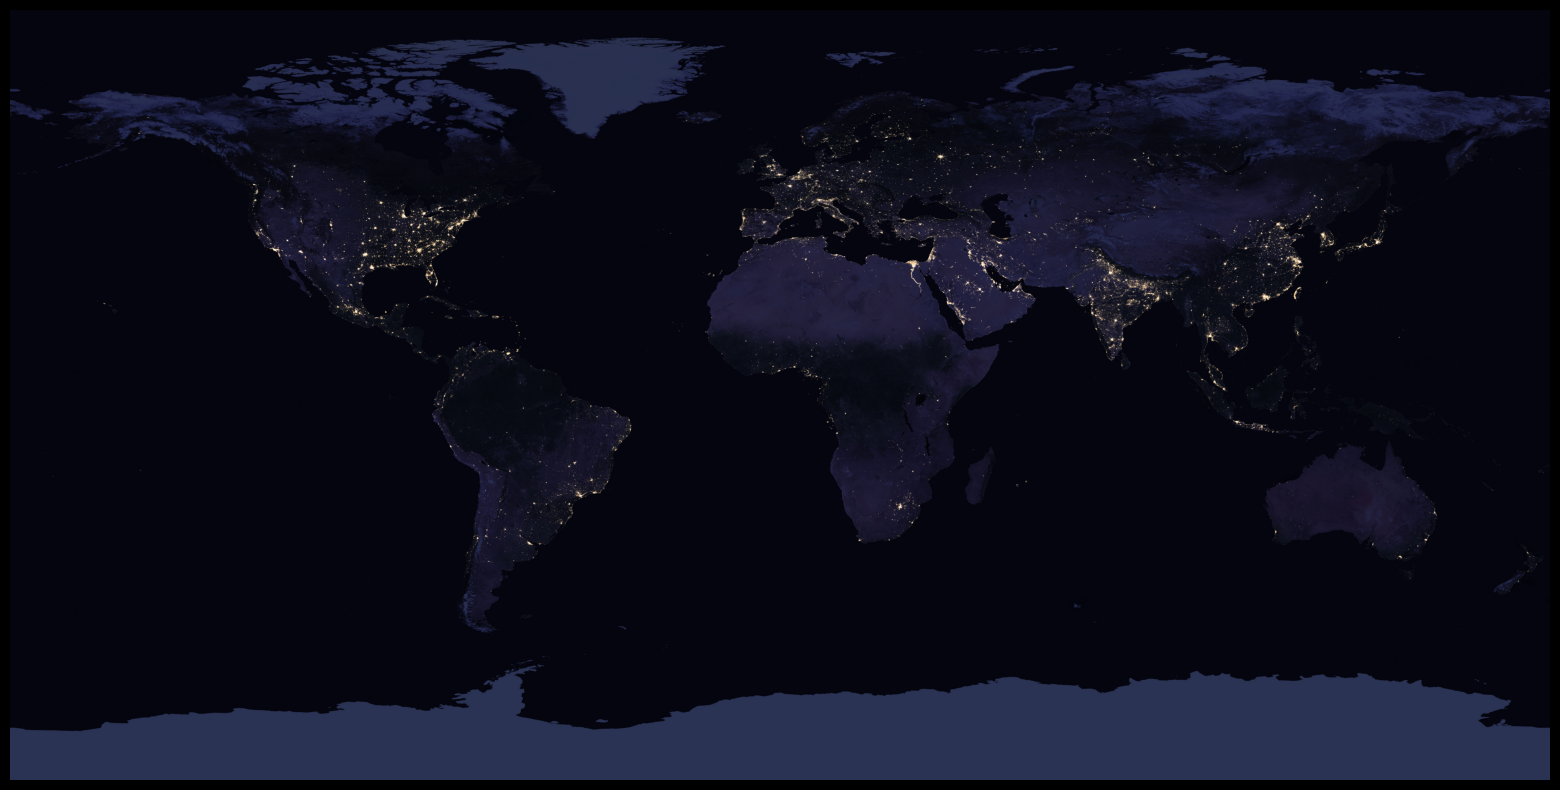

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import urllib.request
from pathlib import Path

# Config - NASA Black Marble Image
img_url = "https://eoimages.gsfc.nasa.gov/images/imagerecords/144000/144898/BlackMarble_2016_3km.jpg"
img_path = Path("night_lights_viirs_WGS84.jpg")

if not img_path.exists():
    print("Downloading high-res night lights map...")
    urllib.request.urlretrieve(img_url, img_path)

# Load Image
img = plt.imread(img_path)

# Plot WGS84
fig = plt.figure(figsize=(20, 10), facecolor='black')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('black')

# Display the global image
# The extent [-180, 180, -90, 90] covers the whole world
ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree())

#plt.title("VIIRS Night Lights - Global WGS84", color='white', size=15)
plt.axis('off')
plt.show()

✅ Saved successfully: GOES_EAST_Night_Lights_UltraRes.jpg


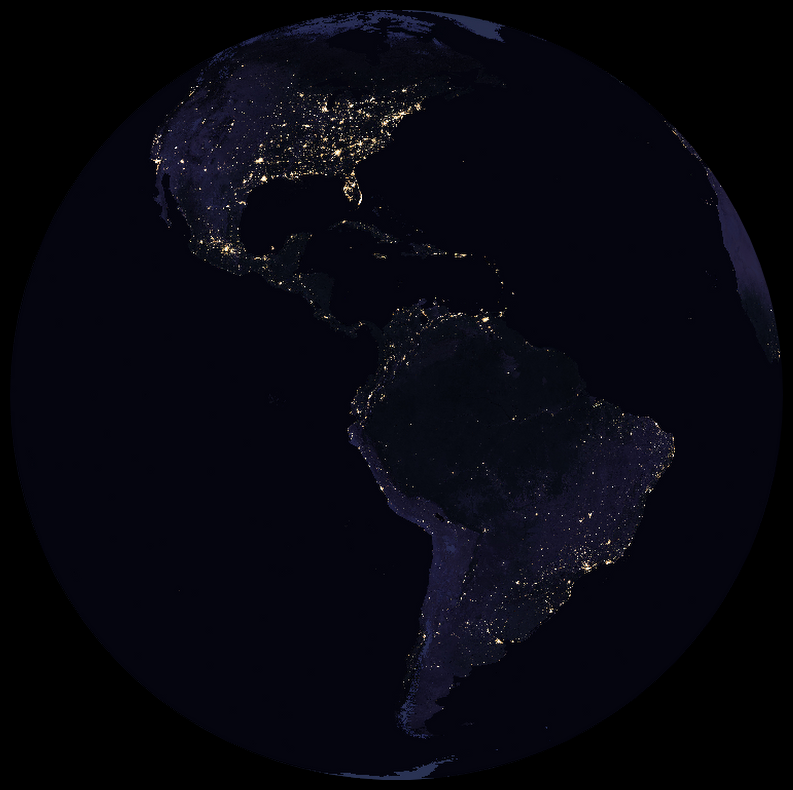

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. EVITAR EL WARNING DE BOMBA DE DESCOMPRESIÓN
# Esto permite procesar imágenes de gran tamaño en memoria
Image.MAX_IMAGE_PIXELS = None 

# Config
img_input = Path("night_lights_viirs_WGS84.jpg")
output_name = "GOES_EAST_Night_Lights_UltraRes.jpg"

if not img_input.exists():
    print(f"❌ Error: File {img_input} not found.")
else:
    img = plt.imread(img_input)
    goes_crs = ccrs.Geostationary(central_longitude=-75.0)

    # Ajustamos figsize a 10x10 para tener mejor control
    fig = plt.figure(figsize=(10, 10), facecolor='black')
    ax = plt.axes(projection=goes_crs)
    ax.set_facecolor('black')
    ax.set_global()

    # Plot
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    plt.axis('off')

    # --- MÉTODO DE GUARDADO SEGURO ---
    # Eliminamos 'quality' y 'optimize' para que sea compatible con todos los backends
    # Si quieres JPG, el backend estándar lo hará por defecto con buena calidad.
    try:
        plt.savefig(
            output_name, 
            dpi=500,                # 10 * 500 = 5000px ancho
            facecolor='black', 
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Saved successfully: {output_name}")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")
        print("Intentando guardar como PNG...")
        plt.savefig(output_name.replace(".jpg", ".png"), dpi=500, facecolor='black', bbox_inches='tight', pad_inches=0)

    plt.show()

✅ Guardado con éxito: GOES_WEST_Night_Lights_UltraRes.jpg
📊 Resolución: 5000x5000 píxeles aprox.


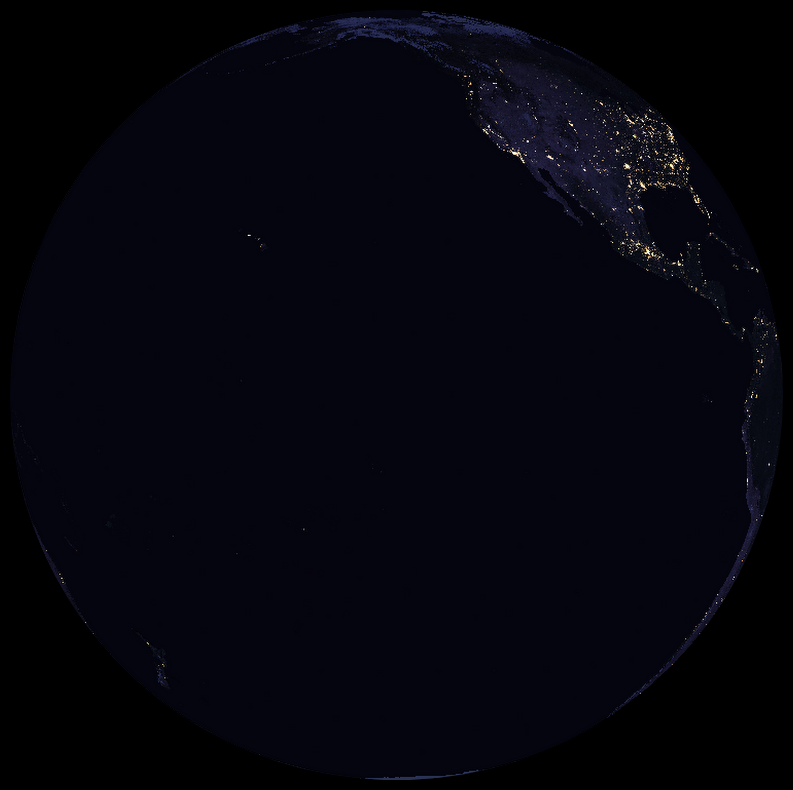

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. PERMITIR IMÁGENES GRANDES (Evita el DecompressionBombWarning)
Image.MAX_IMAGE_PIXELS = None 

# Configuración
img_input = Path("night_lights_viirs_WGS84.jpg")
output_name = "GOES_WEST_Night_Lights_UltraRes.jpg"

if not img_input.exists():
    print(f"❌ Error: No se encuentra el archivo {img_input}")
else:
    img = plt.imread(img_input)
    
    # Definir Proyección GOES-West (-137.0)
    # Esta posición cubre el Pacífico y la costa oeste de las Américas
    goes_west_crs = ccrs.Geostationary(central_longitude=-137.0)

    # Figura de 10x10 pulgadas
    fig = plt.figure(figsize=(10, 10), facecolor='black')
    ax = plt.axes(projection=goes_west_crs)
    ax.set_facecolor('black')
    ax.set_global()

    # Dibujar mapa base
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    plt.axis('off')

    # --- GUARDADO SEGURO ---
    # Usamos dpi=500 para obtener una imagen de 5000x5000 píxeles
    try:
        plt.savefig(
            output_name, 
            dpi=500, 
            facecolor='black', 
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Guardado con éxito: {output_name}")
        print(f"📊 Resolución: 5000x5000 píxeles aprox.")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")

    plt.show()

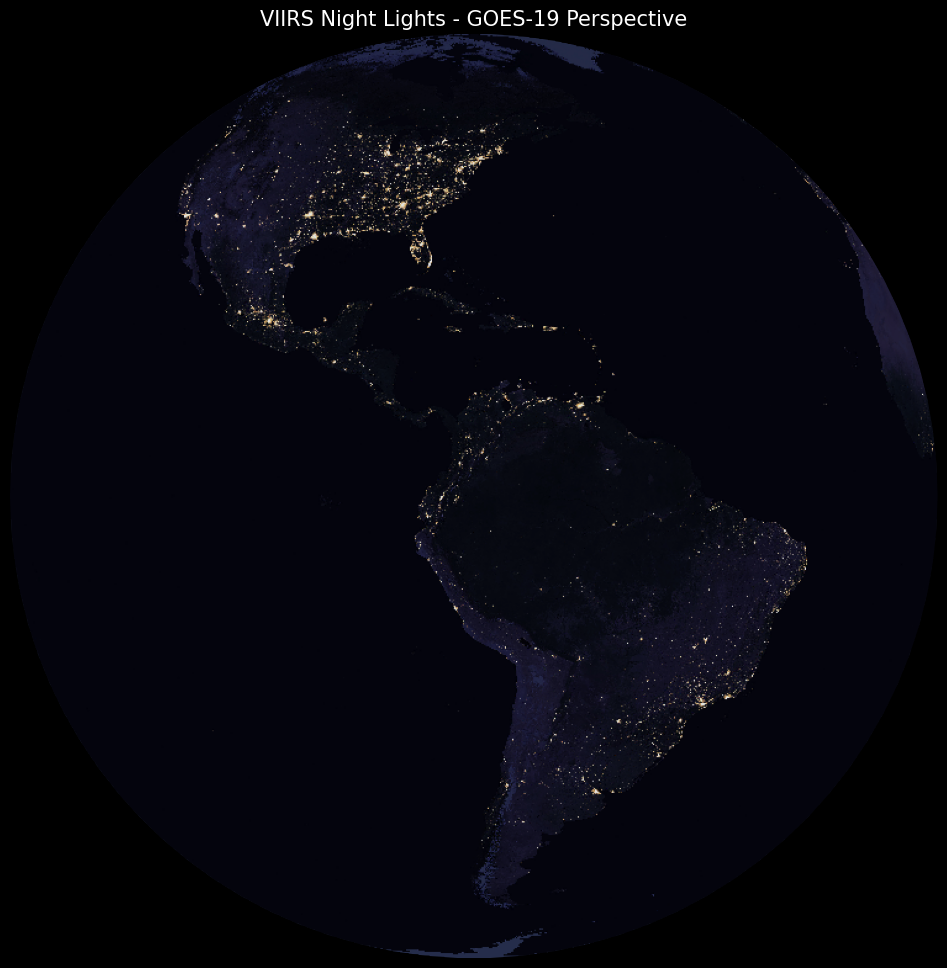

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path

# Load same image
img_path = Path("night_lights_viirs_WGS84.jpg")
if not img_path.exists():
    print("Please run the first script to download the image.")
else:
    img = plt.imread(img_path)

    # Setup GOES-19 Projection
    # GOES-19 is at -75.0 degrees West
    goes_crs = ccrs.Geostationary(central_longitude=-75.0)

    fig = plt.figure(figsize=(12, 12), facecolor='black')
    ax = plt.axes(projection=goes_crs)
    ax.set_facecolor('black')

    # Important: Set global to see the full satellite disk
    ax.set_global()

    # Apply the night lights image to the globe
    # Cartopy automatically re-projects the WGS84 image to the Geostationary view
    ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), alpha=0.9)

    plt.title("VIIRS Night Lights - GOES-19 Perspective", color='white', size=15)
    plt.axis('off')
    plt.show()

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

# Cargar la imagen (asegúrate de que el nombre coincida con tu descarga previa)
img_path = Path("night_lights_viirs.jpg")
img = plt.imread(img_path)

# GOES West position is -137.0 degrees
goes_west_crs = ccrs.Geostationary(central_longitude=-137.0)

fig = plt.figure(figsize=(12, 12), facecolor='black')
ax = plt.axes(projection=goes_west_crs)
ax.set_facecolor('black')

# Important: Set global to see the full satellite disk
ax.set_global()

# Re-project night lights to GOES West
ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], 
          transform=ccrs.PlateCarree(), alpha=0.9)

# Add context features (optional but recommended)
#ax.add_feature(cfeature.COASTLINE, edgecolor='cyan', linewidth=0.6)
#ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.4, alpha=0.5)

#plt.title("VIIRS Night Lights - GOES West Perspective", color='white', size=15)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'night_lights_viirs.jpg'

✅ Guardado con transparencia: GOES_EAST_Transparent_Disk.png


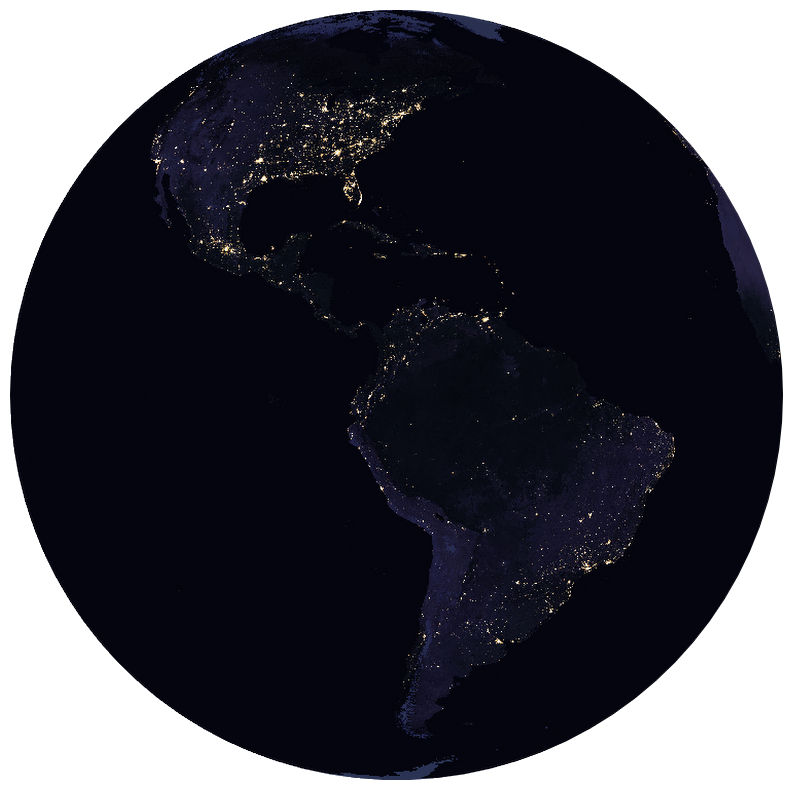

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. Permitir imágenes grandes
Image.MAX_IMAGE_PIXELS = None 

# Configuración
img_input = Path("night_lights_viirs_WGS84.jpg")
# Cambiamos extensión a .png para soportar transparencia
output_name = "GOES_EAST_Transparent_Disk.png"

if not img_input.exists():
    print(f"❌ Error: No se encuentra el archivo {img_input}")
else:
    img = plt.imread(img_input)
    
    # Proyección GOES-East (-75.0)
    goes_crs = ccrs.Geostationary(central_longitude=-75.0)

    # Definimos la figura con fondo transparente
    fig = plt.figure(figsize=(10, 10), facecolor='none') 
    ax = plt.axes(projection=goes_crs)
    
    # Fondo del hacha (el cuadrado) transparente
    ax.set_facecolor('none')
    ax.set_global()

    # Dibujar el mapa base
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    # IMPORTANTE: Quitamos el marco del mapa para que no salga el cuadro negro/blanco
    ax.spines['geo'].set_visible(False)
    plt.axis('off')

    # --- GUARDADO CON TRANSPARENCIA ---
    try:
        plt.savefig(
            output_name, 
            dpi=500, 
            transparent=True,    # Esta es la clave
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Guardado con transparencia: {output_name}")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. Permitir imágenes grandes
Image.MAX_IMAGE_PIXELS = None 

# Configuración
img_input = Path("night_lights_viirs_WGS84.jpg")
# Cambiamos extensión a .png para soportar transparencia
output_name = "GOES_WEST_Transparent_Disk.png"

if not img_input.exists():
    print(f"❌ Error: No se encuentra el archivo {img_input}")
else:
    img = plt.imread(img_input)
    
    # Proyección GOES-West (-137.0)
    goes_crs = ccrs.Geostationary(central_longitude=-137.0)

    # Definimos la figura con fondo transparente
    fig = plt.figure(figsize=(10, 10), facecolor='none') 
    ax = plt.axes(projection=goes_crs)
    
    # Fondo del hacha (el cuadrado) transparente
    ax.set_facecolor('none')
    ax.set_global()

    # Dibujar el mapa base
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    # IMPORTANTE: Quitamos el marco del mapa para que no salga el cuadro negro/blanco
    ax.spines['geo'].set_visible(False)
    plt.axis('off')

    # --- GUARDADO CON TRANSPARENCIA ---
    try:
        plt.savefig(
            output_name, 
            dpi=500, 
            transparent=True,    # Esta es la clave
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Guardado con transparencia: {output_name}")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")

    plt.show()

⏳ Procesando máscara de continentes (esto puede tardar unos segundos)...
✅ ¡Éxito! Mapa WGS84 con océano transparente guardado en: WGS84_Land_Only_Transparent.png


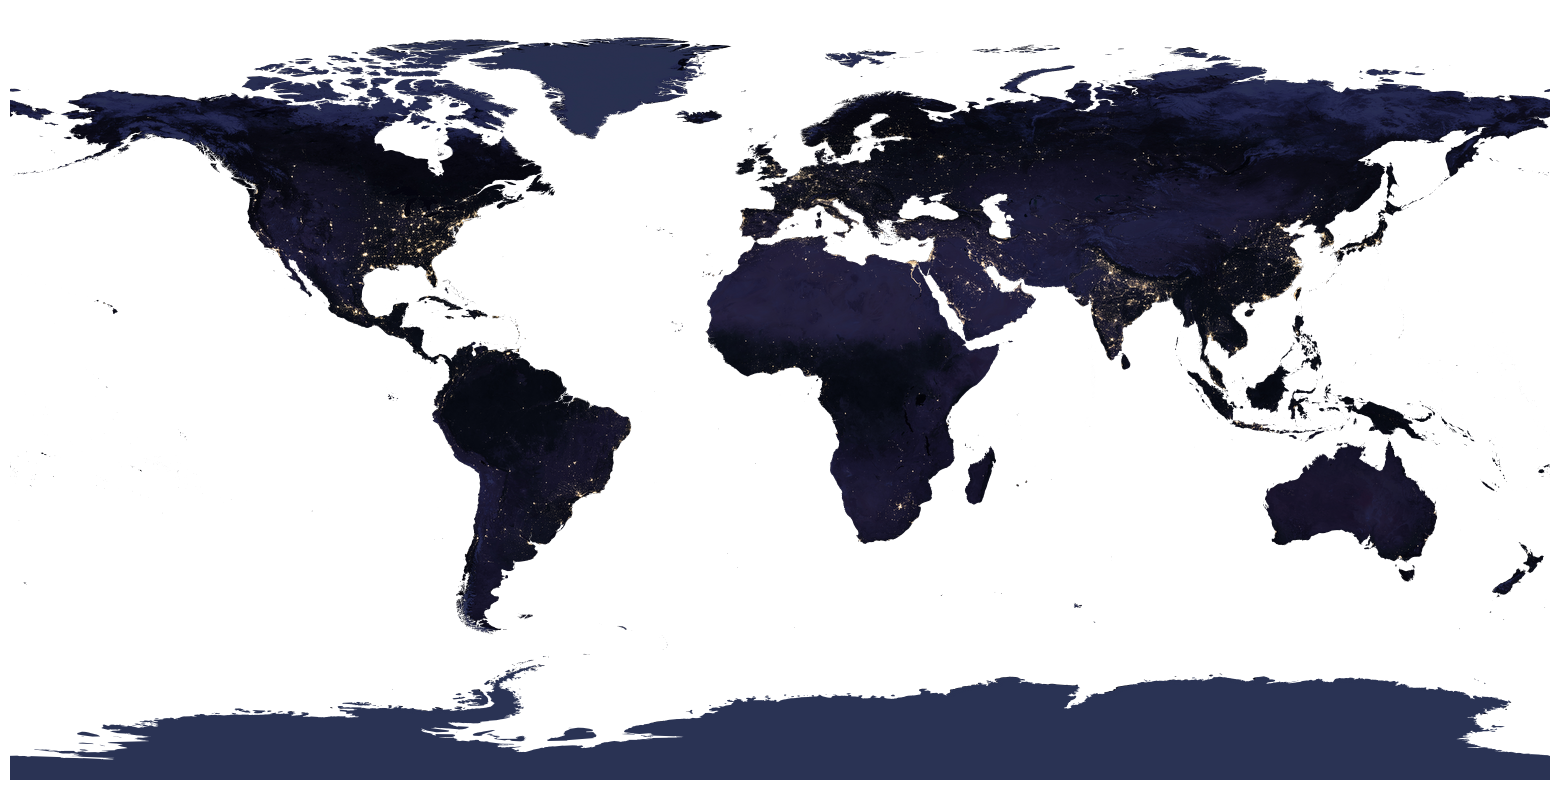

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
from pathlib import Path
from PIL import Image
import numpy as np
from shapely.ops import unary_union

# 1. Seguridad para imágenes grandes
Image.MAX_IMAGE_PIXELS = None 

# Archivos
img_input = Path("night_lights_viirs_WGS84.jpg")
output_name = "WGS84_Land_Only_Transparent.png"

if not img_input.exists():
    print(f"❌ Error: No se encuentra {img_input}")
else:
    img = plt.imread(img_input)
    
    # 2. Setup de la Proyección Plana
    fig = plt.figure(figsize=(20, 10), facecolor='none')
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Hacer el fondo transparente
    ax.patch.set_visible(False)
    
    # FIX: En versiones nuevas de Cartopy, outline_patch no existe.
    # Usamos spines directamente.
    if hasattr(ax, 'spines'):
        ax.spines['geo'].set_visible(False)

    # 3. Dibujar la imagen
    img_plot = ax.imshow(img, origin='upper', 
                         extent=[-180, 180, -90, 90], 
                         transform=ccrs.PlateCarree(), 
                         interpolation='lanczos')

    # 4. --- EL CORTE DEFINITIVO (CLIPPING) ---
    print("⏳ Procesando máscara de continentes (esto puede tardar unos segundos)...")
    land_geom = cfeature.NaturalEarthFeature('physical', 'land', '10m').geometries()
    merged_land = unary_union(list(land_geom))
    
    def shapely_to_path(geom):
        if geom.is_empty: return mpath.Path([(0,0)])
        poly_paths = []
        # Manejar polígonos y multipolígonos de forma segura
        geos = geom.geoms if hasattr(geom, 'geoms') else [geom]
        for poly in geos:
            if poly.is_empty: continue
            paths = [mpath.Path(np.array(poly.exterior.coords))]
            for interior in poly.interiors:
                paths.append(mpath.Path(np.array(interior.coords)))
            poly_paths.append(mpath.Path.make_compound_path(*paths))
        return mpath.Path.make_compound_path(*poly_paths)

    clip_path = shapely_to_path(merged_land)
    
    # Aplicar el recorte a la imagen
    img_plot.set_clip_path(clip_path, transform=ax.transData)

    # 5. Guardado en Alta Resolución
    plt.savefig(
        output_name, 
        dpi=300, 
        transparent=True, 
        bbox_inches='tight', 
        pad_inches=0
    )
    
    print(f"✅ ¡Éxito! Mapa WGS84 con océano transparente guardado en: {output_name}")
    plt.show()